In [35]:
import pandas as pd
import numpy as np
import re
# --------------------
from sklearn.feature_extraction.text import  TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix,classification_report
import math
import unidecode 

In [36]:
df = pd.read_csv('data_defi3.csv.gz',compression="gzip", sep=";")

In [37]:
print(df.info())
print(df['PLT'].unique())
print(df['PLT'].nunique())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23514 entries, 0 to 23513
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Libellé.Prescription  23514 non-null  object 
 1   Avis.Pharmaceutique   23141 non-null  object 
 2   PLT                   23514 non-null  float64
dtypes: float64(1), object(2)
memory usage: 551.2+ KB
None
[ 5.3  4.1  3.1 10.   1.2  1.1  5.1  8.5  6.4  2.2 11.   8.4  6.2  4.2
  9.1  8.1  8.3  6.1  3.2  2.4  8.2  5.2  1.3  2.1  6.3  7. ]
26


In [38]:
df.dropna(inplace=True)

In [39]:
df.head()

,Libellé.Prescription,Avis.Pharmaceutique,PLT
0,"CONTRAMAL 100 MG/ML, GOUTTES BUV (TRAMADOL)",30/12/16 pas d'indication,5.3
1,"IMOVANE 7.5 MG, CPR SÉCABLE (ZOPICLONE)","22/12/16 recommandé -> IMOVANE 3,75MG CP, 1 au...",4.1
2,"COLCHICINE 1 MG, CPR SÉCABLE (COLCHICINE)","au vue de la DFG, il est recommandé d'administ...",4.1
3,"PANTOPRAZOLE 40 MG, CPR GASTRO-RÉSISTANT (EUPA...",Dose curative et absence d'ATCD gastrique retr...,4.1
4,VANCOMYCINE 500 mg 1x/j,posologie infraT veuillez réévaluer la posolog...,3.1


In [40]:
#unaccented_string = unidecode.unidecode(df['Avis.Pharmaceutique'][2])
df['Avis.Pharmaceutique'] = df['Avis.Pharmaceutique'].apply(lambda x : unidecode.unidecode(x)) # Remove é etc and ponctuation

In [41]:
df['Length'] = df['Avis.Pharmaceutique'].str.len()

In [42]:
df.groupby('PLT').describe()

Length                                                           
       count        mean        std   min     25%    50%     75%    max
PLT                                                                    
1.1   9898.0   82.472419  38.100831   6.0   55.00   75.0  102.00  264.0
1.2   1226.0  100.356444  51.702029   7.0   64.00   90.0  124.00  397.0
1.3    139.0  108.345324  63.533024  22.0   65.00   93.0  133.00  455.0
2.1     77.0  113.077922  48.834513  21.0   74.00  110.0  149.00  224.0
2.2    279.0   92.455197  38.071175  23.0   65.00   82.0  113.00  242.0
2.4    400.0   82.142500  42.028361  20.0   55.00   69.0   97.00  250.0
3.1    944.0   87.784958  44.742261  13.0   53.75   81.0  111.00  247.0
3.2     25.0   81.840000  50.027226  14.0   47.00   70.0  105.00  242.0
4.1   2397.0   78.578640  41.553656   8.0   51.00   68.0   97.00  311.0
4.2    667.0   79.170915  39.024104   9.0   51.00   72.0   99.00  261.0
5.1    515.0   78.801942  46.932102   6.0   44.00   71.0  101.00  243.0
5.2     31.0  127.903226  43.252248  50.0  107.50  134.0  153.50  209.0
5.3    286.0   95.510490  51.235797  20.0   57.00   86.0  123.00  261.0
6.1      3.0  129.333333  82.470197  64.0   83.00  102.0  162.00  222.0
6.2    331.0   93.803625  49.881868  21.0   57.00   76.0  126.50  245.0
6.3     88.0  139.352273  57.454838  37.0   92.50  129.5  179.75  291.0
6.4    544.0  138.106618  56.856056  18.0   91.00  139.0  184.25  323.0
7.0      8.0  122.750000  57.794587  48.0   97.25  124.5  139.00  234.0
8.1     56.0   45.053571  14.997478  24.0   32.00   45.0   50.25  110.0
8.2    377.0   95.493369  48.706302  12.0   60.00   91.0  123.00  249.0
8.3   1049.0   64.898951  38.405099   7.0   36.00   55.0   84.00  231.0
8.4    371.0   77.514825  36.718677  13.0   51.00   72.0   95.00  244.0
8.5   1093.0   88.214090  45.883791  10.0   55.00   79.0  112.00  266.0
9.1     20.0  127.700000  68.894351  37.0   73.50  109.0  185.75  251.0
10.0   738.0   77.596206  49.289520   3.0   40.00   65.0  100.00  251.0
11.0  1579.0   53.234326  30.620115   2.0   31.00   45.0   68.00  217.0

<AxesSubplot:ylabel='Frequency'>

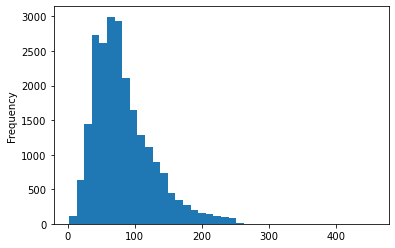

In [43]:
df['Length'].plot(bins=40, kind='hist') 

In [44]:
df['PLT'] = df['PLT'].apply(lambda x : math.floor(x))

In [45]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [46]:
df['Avis.Pharmaceutique'] = df['Avis.Pharmaceutique'].apply(lambda x : preprocess_text(x))
df['Avis.Pharmaceutique'] = df['Avis.Pharmaceutique'].str.lower()

In [47]:
stop_word = ["a","abord","absolument","afin","ah","ai","aie","aient","aies","ailleurs","ainsi","ait","allaient",
             "allo","allons","allô","alors","anterieur","anterieure","anterieures","apres","après","as","assez",
             "attendu","au","aucun","aucune","aucuns","aujourd","aujourd'hui","aupres","auquel","aura","aurai",
             "auraient","aurais","aurait","auras","aurez","auriez","aurions","aurons","auront","aussi","autant",
             "autre","autrefois","autrement","autres","autrui","aux","auxquelles","auxquels","avaient","avais",
             "avait","avant","avec","avez","aviez","avions","avoir","avons","ayant","ayez","ayons","b","bah",
             "bas","basee","bat","beau","beaucoup","bien","bigre","bon","boum","bravo","brrr","c","car","ce",
             "ceci","cela","celle","celle-ci","celle-là","celles","celles-ci","celles-là","celui","celui-ci",
             "celui-là","celà","cent","cependant","certain","certaine","certaines","certains","certes","ces",
             "cet","cette","ceux","ceux-ci","ceux-là","chacun","chacune","chaque","cher","chers","chez","chiche",
             "chut","chère","chères","ci","cinq","cinquantaine","cinquante","cinquantième","cinquième","clac","clic",
             "combien","comme","comment","comparable","comparables","compris","concernant","contre","couic",
             "crac","d","da","dans","de","debout","dedans","dehors","deja","delà","depuis","dernier","derniere",
             "derriere","derrière","des","desormais","desquelles","desquels","dessous","dessus","deux","deuxième",
             "deuxièmement","devant","devers","devra","devrait","different","differentes","differents","différent",
             "différente","différentes","différents","dire","directe","directement","dit","dite","dits","divers",
             "diverse","diverses","dix","dix-huit","dix-neuf","dix-sept","dixième","doit","doivent","donc","dont",
             "dos","douze","douzième","dring","droite","du","duquel","durant","dès","début","désormais","e","effet",
             "egale","egalement","egales","eh","elle","elle-même","elles","elles-mêmes","en","encore","enfin","entre","envers","environ","es","essai","est","et","etant","etc","etre","eu","eue","eues","euh","eurent","eus","eusse","eussent","eusses","eussiez","eussions","eut","eux","eux-mêmes","exactement","excepté","extenso","exterieur","eûmes","eût","eûtes","f","fais","faisaient","faisant","fait","faites","façon","feront","fi","flac","floc","fois","font","force","furent","fus","fusse","fussent","fusses","fussiez","fussions","fut","fûmes","fût","fûtes","g","gens","h","ha","haut","hein","hem","hep","hi","ho","holà","hop","hormis","hors","hou","houp","hue","hui","huit","huitième","hum","hurrah","hé","hélas","i","ici","il","ils","importe","j","je","jusqu","jusque","juste","k","l","la","laisser","laquelle","las","le","lequel","les","lesquelles","lesquels","leur","leurs","longtemps","lors","lorsque","lui","lui-meme","lui-même","là","lès","m","ma","maint","maintenant","mais","malgre","malgré","maximale","me","meme","memes","merci","mes","mien","mienne","miennes","miens","mille","mince","mine","minimale","moi","moi-meme","moi-même","moindres","moins","mon","mot","moyennant","multiple","multiples","même","mêmes","n","na","naturel","naturelle","naturelles","ne","neanmoins","necessaire","necessairement","neuf","neuvième","ni","nombreuses","nombreux","nommés","non","nos","notamment","notre","nous","nous-mêmes","nouveau","nouveaux","nul","néanmoins","nôtre","nôtres","o","oh","ohé","ollé","olé","on","ont","onze","onzième","ore","ou","ouf","ouias","oust","ouste","outre","ouvert","ouverte","ouverts","o|","où","p","paf","pan","par","parce","parfois","parle","parlent","parler","parmi","parole","parseme","partant","particulier","particulière","particulièrement","pas","passé","pendant","pense","permet","personne","personnes","peu","peut","peuvent","peux","pff","pfft","pfut","pif","pire","pièce","plein","plouf","plupart","plus","plusieurs","plutôt","possessif","possessifs","possible","possibles","pouah","pour","pourquoi","pourrais","pourrait","pouvait","prealable","precisement","premier","première","premièrement","pres","probable","probante","procedant","proche","près","psitt","pu","puis","puisque","pur","pure","q","qu","quand","quant","quant-à-soi","quanta","quarante","quatorze","quatre","quatre-vingt","quatrième","quatrièmement","que","quel","quelconque","quelle","quelles","quelqu'un","quelque","quelques","quels","qui","quiconque","quinze","quoi","quoique","r","rare","rarement","rares","relative","relativement","remarquable","rend","rendre","restant","reste","restent","restrictif","retour","revoici","revoilà","rien","s","sa","sacrebleu","sait","sans","sapristi","sauf","se","sein","seize","selon","semblable","semblaient","semble","semblent","sent","sept","septième","sera","serai","seraient","serais","serait","seras","serez","seriez","serions","serons","seront","ses","seul","seule","seulement","si","sien","sienne","siennes","siens","sinon","six","sixième","soi","soi-même","soient","sois","soit","soixante","sommes","son","sont","sous","souvent","soyez","soyons","specifique","specifiques","speculatif","stop","strictement","subtiles","suffisant","suffisante","suffit","suis","suit","suivant","suivante","suivantes","suivants","suivre","sujet","superpose","sur","surtout","t","ta","tac","tandis","tant","tardive","te","tel","telle","tellement","telles","tels","tenant","tend","tenir","tente","tes","tic","tien","tienne","tiennes","tiens","toc","toi","toi-même","ton","touchant","toujours","tous","tout","toute","toutefois","toutes","treize","trente","tres","trois","troisième","troisièmement","trop","très","tsoin","tsouin","tu","té","u","un","une","unes","uniformement","unique","uniques","uns","v","va","vais","valeur","vas","vers","via","vif","vifs","vingt","vivat","vive","vives","vlan","voici","voie","voient","voilà","voire","vont","vos","votre","vous","vous-mêmes","vu","vé","vôtre","vôtres","w","x","y","z","zut","à","â","ça","ès","étaient","étais","était","étant","état","étiez","étions","été","étée","étées","étés","êtes","être","ô"]


In [48]:
df['Avis.Pharmaceutique'] = df['Avis.Pharmaceutique'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_word)]))

In [49]:
plt = pd.get_dummies(df.PLT.astype(str))

In [50]:
plt.head()

,1,10,11,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0


In [51]:
plt_col_names = plt.columns

In [52]:
df.head()

,Libellé.Prescription,Avis.Pharmaceutique,PLT,Length
0,"CONTRAMAL 100 MG/ML, GOUTTES BUV (TRAMADOL)",indication,5,26
1,"IMOVANE 7.5 MG, CPR SÉCABLE (ZOPICLONE)",recommande imovane mg cp coucher eb,4,59
2,"COLCHICINE 1 MG, CPR SÉCABLE (COLCHICINE)",vue dfg recommande administrer mg donnees gpr ...,4,113
3,"PANTOPRAZOLE 40 MG, CPR GASTRO-RÉSISTANT (EUPA...",dose curative absence atcd gastrique retrouve ...,4,108
4,VANCOMYCINE 500 mg 1x/j,posologie infrat veuillez reevaluer posologie ...,3,77


#### Frequency of word list

In [53]:
cv = CountVectorizer()
cv_fit = cv.fit_transform(df['Avis.Pharmaceutique'])

In [54]:
word_list = cv.get_feature_names()
count_list = cv_fit.toarray().sum(axis=0)
dict_list = dict(zip(word_list,count_list))
dict_list = sorted(dict_list.items(), key=lambda item: item[1],reverse=True)
dict_list[:20]

[('mg', 13380),
 ('cp', 4519),
 ('jour', 3751),
 ('propose', 3479),
 ('hus', 3252),
 ('proposons', 2776),
 ('cpr', 2342),
 ('reference', 2259),
 ('prescrire', 2176),
 ('refuse', 2041),
 ('posologie', 1972),
 ('motif', 1899),
 ('prescription', 1684),
 ('pantoprazole', 1597),
 ('andrea', 1534),
 ('agnes', 1525),
 ('revoir', 1411),
 ('ml', 1404),
 ('patient', 1324),
 ('substituer', 1207)]

#### Simple Way

In [55]:
pipeline = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [56]:
X = df['Avis.Pharmaceutique']
y = df['PLT']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state = 42, stratify=y)

In [57]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [58]:
predictions = pipeline.predict(X_test)

In [59]:
predictions

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [60]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[3184    5    1  105    2   13    0   59    0    0   10]
 [ 121   94    0    3    0    0    0    7    0    0    2]
 [ 186    0   16   69    0    0    0   15    0    4    1]
 [ 181    1    0  696    1    0    0   35    0    2    3]
 [ 117    0    0   81   43    2    0    6    0    0    1]
 [  34    0    1   20    1  212    0   19    0    2    1]
 [   0    0    0    0    0    2    0    0    0    0    0]
 [ 279    0    0   54    0    1    0  544    0    1    5]
 [   0    0    0    1    0    0    0    5    0    0    0]
 [  45    0    2   85    1    9    0    7    0   71    1]
 [ 276    0    0   88    0    2    0   31    0    2   75]]
              precision    recall  f1-score   support

           1       0.72      0.94      0.82      3379
           2       0.94      0.41      0.57       227
           3       0.80      0.05      0.10       291
           4       0.58      0.76      0.66       919
           5       0.90      0.17      0.29       250
           6       0.88      0.73   

C:\Users\murat\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\murat\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\murat\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [61]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[3184    5    1  105    2   13    0   59    0    0   10]
 [ 121   94    0    3    0    0    0    7    0    0    2]
 [ 186    0   16   69    0    0    0   15    0    4    1]
 [ 181    1    0  696    1    0    0   35    0    2    3]
 [ 117    0    0   81   43    2    0    6    0    0    1]
 [  34    0    1   20    1  212    0   19    0    2    1]
 [   0    0    0    0    0    2    0    0    0    0    0]
 [ 279    0    0   54    0    1    0  544    0    1    5]
 [   0    0    0    1    0    0    0    5    0    0    0]
 [  45    0    2   85    1    9    0    7    0   71    1]
 [ 276    0    0   88    0    2    0   31    0    2   75]]
              precision    recall  f1-score   support

           1       0.72      0.94      0.82      3379
           2       0.94      0.41      0.57       227
           3       0.80      0.05      0.10       291
           4       0.58      0.76      0.66       919
           5       0.90      0.17      0.29       250
           6       0.88      0.73   

C:\Users\murat\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\murat\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\murat\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[5439  145]
 [ 554  805]]
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      5584
           1       0.85      0.59      0.70      1359

    accuracy                           0.90      6943
   macro avg       0.88      0.78      0.82      6943
weighted avg       0.90      0.90      0.89      6943



In [ ]:

#df['Avis.Pharmaceutique'].apply(lambda w : w for w in df['Avis.Pharmaceutique'].split() if not w in stop_word)
#df['Avis.Pharmaceutique'] = df['Avis.Pharmaceutique'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_word)]))


#### DEEP 

In [ ]:
#pip install keras

In [ ]:
#pip install tensorflow

In [86]:
import nltk
#nltk.download('punkt')
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, Conv1D
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from tensorflow.keras.layers import Embedding
from keras_preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report,confusion_matrix
from keras.preprocessing.text import one_hot
from nltk.tokenize import word_tokenize
from keras import layers


In [87]:
#pip install nltk

In [88]:
X = df['Avis.Pharmaceutique']
#y = df['PLT']
y = plt
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42,stratify=y)

In [89]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(X_train[2])


[32, 5, 6, 184, 374, 30, 28, 570, 3, 41]


In [ ]:
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [90]:
maxlen = 40
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0, :])

[ 20 206   1   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0]


In [91]:
# from sklearn.feature_extraction.text import TfidfTransformer

In [92]:
# tfidf_transformer = TfidfTransformer().fit(X_train)
# tfidf = tfidf_transformer.transform(X_train)
# tfidf = tfidf.toarray()
# tfidf_transformer_t = TfidfTransformer().fit(X_test)
# tfidf_t = tfidf_transformer_t.transform(X_test)
# tfidf_t = tfidf_t.toarray()

In [93]:
# ### TFID versio

# history = model.fit(tfidf, y_train,
#                     epochs=8,
#                     verbose=1,
#                     validation_data=(tfidf_t, y_test),
#                     batch_size=10,class_weight={0:0.6,1:2.5})
# loss, accuracy = model.evaluate(tfidf, y_train, verbose=False)
# print("Training Accuracy: {:.4f}".format(accuracy))
# loss, accuracy = model.evaluate(tfidf_t, y_test, verbose=False)
# print("Testing Accuracy:  {:.4f}".format(accuracy))
# plot_history(history)

In [94]:
print(X_train.shape)

(18512, 40)


In [95]:
# y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
# y_test = np.asarray(y_test).astype('float32').reshape((-1,1))

In [96]:
# embedding_dim = 40

# model = Sequential()
# model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
# model.add(Conv1D(50, 5))
# model.add(Flatten())
# model.add(Dense(50, activation='relu'))
# model.add(layers.Dense(1, activation='sigmoid'))
# model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])


In [97]:
# Multi label
embedding_dim = 40

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(Conv1D(50, 5))
model.add(Dense(120, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
#model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Flatten())
model.add(layers.Dense(11, activation='softmax'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [98]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 40, 40)            228600    
                                                                 
 conv1d_3 (Conv1D)           (None, 36, 50)            10050     
                                                                 
 dense_12 (Dense)            (None, 36, 120)           6120      
                                                                 
 dropout_6 (Dropout)         (None, 36, 120)           0         
                                                                 
 dense_13 (Dense)            (None, 36, 100)           12100     
                                                                 
 dropout_7 (Dropout)         (None, 36, 100)           0         
                                                                 
 dense_14 (Dense)            (None, 36, 50)           

In [106]:

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=40))
model.add(LSTM(128,input_shape=(X_train.shape),activation='relu',return_sequences=True))
model.add(Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(11, activation='softmax'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 40, 50)            285750    
                                                                 
 lstm_2 (LSTM)               (None, 40, 128)           91648     
                                                                 
 dropout_12 (Dropout)        (None, 40, 128)           0         
                                                                 
 flatten_6 (Flatten)         (None, 5120)              0         
                                                                 
 dense_20 (Dense)            (None, 128)               655488    
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_21 (Dense)            (None, 64)               

In [107]:
# Multi
history = model.fit(X_train, y_train,
                    epochs=15,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    batch_size=10,)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
#

Epoch 1/15
1852/1852 [==============================] - 29s 15ms/step - loss: 0.4845 - accuracy: 0.5615 - val_loss: 0.1340 - val_accuracy: 0.6729
Epoch 2/15
1852/1852 [==============================] - 28s 15ms/step - loss: 0.1262 - accuracy: 0.7066 - val_loss: 0.1198 - val_accuracy: 0.7265
Epoch 3/15
1852/1852 [==============================] - 28s 15ms/step - loss: 0.1068 - accuracy: 0.7577 - val_loss: 0.1161 - val_accuracy: 0.7501
Epoch 4/15
1852/1852 [==============================] - 28s 15ms/step - loss: 0.0940 - accuracy: 0.7953 - val_loss: 0.1147 - val_accuracy: 0.7585
Epoch 5/15
1852/1852 [==============================] - 28s 15ms/step - loss: 0.0847 - accuracy: 0.8190 - val_loss: 0.1191 - val_accuracy: 0.7712
Epoch 6/15
1852/1852 [==============================] - 28s 15ms/step - loss: 0.0780 - accuracy: 0.8355 - val_loss: 0.1244 - val_accuracy: 0.7758
Epoch 7/15
1852/1852 [==============================] - 28s 15ms/step - loss: 0.0709 - accuracy: 0.8526 - val_loss: 0.1241 -

In [ ]:
# Binary, 

# history = model.fit(X_train, y_train,
#                     epochs=10,
#                     verbose=1,
#                     validation_data=(X_test, y_test),
#                     batch_size=10,class_weight={0:0.6,1:2.5})
# loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
# print("Training Accuracy: {:.4f}".format(accuracy))
# loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
# print("Testing Accuracy:  {:.4f}".format(accuracy))
# plot_history(history)

In [89]:
#predictions = model.predict(X_test.tolist())

145/145 [==============================] - 0s 1ms/step


In [108]:
pred = model.predict(X_test)

145/145 [==============================] - 1s 6ms/step


In [109]:
predi = pd.DataFrame(pred)
predi.columns = plt_col_names
predi['P'] = predi.idxmax(axis=1)
predi.head()

,1,10,11,2,3,4,5,6,7,8,9,P
0,0.043097,0.008236,0.666212,7.343922e-04,0.082204,0.123059,2.341915e-03,1.527170e-03,1.161110e-07,0.072565,2.280963e-05,11
1,0.004550,0.000097,0.000431,8.078399e-07,0.991486,0.003420,3.786215e-07,8.895019e-08,1.040111e-15,0.000015,7.993828e-13,3
2,0.038707,0.143689,0.600332,5.433036e-04,0.112537,0.069494,2.622039e-03,2.369120e-03,3.223272e-07,0.029673,3.280154e-05,11
3,0.703995,0.000706,0.014434,4.039581e-02,0.135997,0.072802,1.222487e-03,3.920927e-04,1.237376e-05,0.030017,2.645544e-05,1
4,0.000115,0.998995,0.000519,1.361130e-06,0.000252,0.000103,5.077200e-06,4.950882e-06,2.298602e-12,0.000006,1.065086e-09,10


In [110]:
y_test_t = y_test.idxmax(axis=1)

In [111]:
print(classification_report(y_test_t,predi['P']))
print(confusion_matrix(y_test_t,predi['P']))

              precision    recall  f1-score   support

           1       0.89      0.88      0.88      2253
          10       0.74      0.70      0.72       148
          11       0.51      0.63      0.56       316
           2       0.66      0.74      0.70       151
           3       0.43      0.34      0.38       194
           4       0.76      0.73      0.74       613
           5       0.55      0.63      0.59       166
           6       0.82      0.80      0.81       193
           7       0.00      0.00      0.00         2
           8       0.74      0.72      0.73       589
           9       0.00      0.00      0.00         4

    accuracy                           0.78      4629
   macro avg       0.55      0.56      0.56      4629
weighted avg       0.78      0.78      0.78      4629

[[1987    5   57   33   34   41   30   14    0   52    0]
 [   6  103   12    2    5    5    9    2    0    4    0]
 [  44    5  198    3   10   22    9    0    0   25    0]
 [  28    0  

C:\Users\murat\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\murat\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\murat\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Validation Data

In [156]:
df_val = pd.read_csv('valid_set.csv.gz',compression="gzip", sep=";")

In [157]:
def clean_text (df):
    df.dropna(inplace=True)
    df['Avis.Pharmaceutique'] = df['Avis.Pharmaceutique'].apply(lambda x : unidecode.unidecode(x)) # Remove é etc and ponctuation
    df['Avis.Pharmaceutique'] = df['Avis.Pharmaceutique'].apply(lambda x : preprocess_text(x))
    df['Avis.Pharmaceutique'] = df['Avis.Pharmaceutique'].str.lower()
    df['Avis.Pharmaceutique'] = df['Avis.Pharmaceutique'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_word)]))
    return df

In [158]:
df_v = clean_text(df_val)

In [159]:
df_v = df_v['Avis.Pharmaceutique']

In [160]:
X_v = tokenizer.texts_to_sequences(df_v)
X_v = pad_sequences(X_v, padding='post', maxlen=maxlen)

In [161]:
X_v

array([[ 57, 210, 757, ...,   0,   0,   0],
       [  4,  65,  84, ...,   0,   0,   0],
       [  8,   5,   4, ...,   0,   0,   0],
       ...,
       [  6, 390, 201, ...,   0,   0,   0],
       [ 27, 243,   6, ...,   0,   0,   0],
       [ 62,   1, 124, ...,   0,   0,   0]])

In [162]:
pred_v = model.predict(X_v)

128/128 [==============================] - 1s 6ms/step


In [163]:
predi = pd.DataFrame(pred_v)
predi.columns = plt_col_names
predi['Predictions'] = predi.idxmax(axis=1)
predi.head()

,1,10,11,2,3,4,5,6,7,8,9,Predictions
0,1.752227e-13,2.039549e-18,1.644568e-24,7.713969e-24,6.003013e-33,6.062264e-20,1.947168e-19,1.000000e+00,4.940790e-25,1.576730e-14,1.779579e-25,6
1,2.861907e-02,9.647001e-04,1.825855e-03,9.605933e-01,3.726687e-04,4.315861e-03,1.344373e-03,2.513776e-04,1.628812e-04,8.510332e-04,6.987815e-04,2
2,1.000000e+00,2.887128e-20,1.793845e-16,3.558812e-14,2.419227e-14,4.629391e-14,5.367340e-22,3.095553e-23,3.718449e-34,3.126978e-13,0.000000e+00,1
3,3.187413e-16,3.828002e-21,7.073447e-16,1.892341e-20,5.567656e-19,1.000000e+00,2.492634e-14,6.318689e-26,0.000000e+00,5.713979e-16,0.000000e+00,4
4,1.000000e+00,4.218015e-24,7.324268e-20,9.778635e-17,4.427495e-17,3.886053e-17,6.852697e-27,2.607744e-28,0.000000e+00,1.797661e-16,0.000000e+00,1


In [ ]:
predi.columns

Index(['1', '10', '11', '2', '3', '4', '5', '6', '7', '8', '9', 'Predictions'], dtype='object')

In [165]:
predi = predi.drop(['1', '10', '11', '2', '3', '4', '5', '6', '7', '8', '9'],axis=1)

In [169]:
predi.value_counts()

Predictions
1              1977
4               549
8               500
11              326
6               166
5               151
2               141
3               138
10              124
9                 2
dtype: int64

In [171]:
predi.to_csv('Validation_prediction_Multi_labels')

In [172]:
pd.read_csv("Validation_prediction_Multi_labels")

,Unnamed: 0,Predictions
0,0,6
1,1,2
2,2,1
3,3,4
4,4,1
...,...,...
4069,4069,1
4070,4070,1
4071,4071,2
4072,4072,1


#### Test 

In [176]:
# pred = [1 if p > 0.5 else 0 for p in pred ]

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [92]:
# print(classification_report(y_test,pred))
# print(confusion_matrix(y_test,pred))

              precision    recall  f1-score   support

           0       0.95      0.89      0.92      3723
           1       0.65      0.81      0.72       906

    accuracy                           0.88      4629
   macro avg       0.80      0.85      0.82      4629
weighted avg       0.89      0.88      0.88      4629

[[3330  393]
 [ 174  732]]


### Text processing (test)

In [81]:
X = df['Avis.Pharmaceutique']
y = df['PLT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [82]:
corpus = X_train
corpus_test = X_test
all_words = []
for sent in corpus:
    tokenize_word = word_tokenize(sent)
    for word in tokenize_word:
        all_words.append(word)
all_words_test = []       
for sent in corpus_test:
    tokenize_word = word_tokenize(sent)
    for word in tokenize_word:
        all_words_test.append(word)

In [83]:
unique_words = set(all_words)
unique_words_t = set(all_words_test)
print(len(unique_words))

5769


In [84]:
vocab_length = len(unique_words)
vocab_length_t = len(unique_words_t)


In [113]:
embedded_sentences = [one_hot(sent, vocab_length) for sent in corpus]
embedded_sentences_t = [one_hot(sent, vocab_length_t) for sent in corpus_test]

In [114]:
word_count = lambda sentence: len(word_tokenize(sentence))
longest_sentence = max(corpus, key=word_count)
length_long_sentence = len(word_tokenize(longest_sentence))

In [115]:
len(word_tokenize(longest_sentence))

31

In [116]:
padded_sentences = pad_sequences(embedded_sentences, length_long_sentence, padding='post')
padded_sentences_t = pad_sequences(embedded_sentences_t, length_long_sentence, padding='post')
print(padded_sentences)

[[1958 1026 4821 ...    0    0    0]
 [ 792 2708 3983 ...    0    0    0]
 [2230 4869 5531 ...    0    0    0]
 ...
 [3966 2953 2551 ...    0    0    0]
 [5409 5105 4749 ...    0    0    0]
 [2230 2953 2551 ...    0    0    0]]


In [117]:
print(padded_sentences.shape)
print(padded_sentences_t.shape)

(18512, 31)
(4629, 31)


In [118]:
model=Sequential()
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [137]:
embedding_vector_features=45
model=Sequential()
model.add(Embedding(vocab_length,embedding_vector_features,input_length=length_long_sentence))
model.add(LSTM(128,input_shape=(padded_sentences.shape),activation='relu',return_sequences=True))
model.add(Dropout(0.2))
#model.add(LSTM(128,activation='relu'))
#model.add(Dropout(0.2))
# for units in [128,128,64,32]:

# model.add(Dense(units,activation='relu'))

# model.add(Dropout(0.2))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

print(model.summary())

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 31, 45)            259605    
                                                                 
 lstm_4 (LSTM)               (None, 31, 128)           89088     
                                                                 
 dropout_9 (Dropout)         (None, 31, 128)           0         
                                                                 
 dense_42 (Dense)            (None, 31, 32)            4128      
                                                                 
 dropout_10 (Dropout)        (None, 31, 32)            0         
                                                                 
 dense_43 (Dense)            (None, 31, 1)             33        
                                                                 
Total params: 352,854
Trainable params: 352,854
Non-t

In [248]:
model = Sequential()
model.add(Embedding(vocab_length, 20, input_length=length_long_sentence))
model.add(Flatten())
#model.add(Dense(120, activation='relu'))
#model.add(Dropout(0.2))
#model.add(Dense(units=60,activation='relu'))
#model.add(Dropout(0.5))
#model.add(Dense(units=15,activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [135]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_length, 
                           output_dim=embedding_dim, 
                           input_length=length_long_sentence))
model.add(LSTM(128,input_shape=(padded_sentences.shape),activation='relu',return_sequences=True))
model.add(Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(20, activation='relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 31, 50)            288450    
                                                                 
 lstm_3 (LSTM)               (None, 31, 128)           91648     
                                                                 
 dropout_7 (Dropout)         (None, 31, 128)           0         
                                                                 
 flatten_20 (Flatten)        (None, 3968)              0         
                                                                 
 dense_40 (Dense)            (None, 20)                79380     
                                                                 
 dropout_8 (Dropout)         (None, 20)                0         
                                                                 
 dense_41 (Dense)            (None, 10)              

In [62]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())
#model.compile(loss='binary_crossentropy',optimizer='adam')

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 31, 50)            288450    
                                                                 
 lstm_1 (LSTM)               (None, 31, 128)           91648     
                                                                 
 dropout_3 (Dropout)         (None, 31, 128)           0         
                                                                 
 flatten_4 (Flatten)         (None, 3968)              0         
                                                                 
 dense_8 (Dense)             (None, 10)                39690     
                                                                 
 dropout_4 (Dropout)         (None, 10)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                

In [63]:
model.fit(padded_sentences, y_train, epochs=20,verbose=1)

Epoch 1/20
579/579 [==============================] - 12s 18ms/step - loss: 1.0500 - accuracy: 0.8663
Epoch 2/20
579/579 [==============================] - 11s 18ms/step - loss: 0.2136 - accuracy: 0.9129
Epoch 3/20
579/579 [==============================] - 11s 19ms/step - loss: 0.8119 - accuracy: 0.9187
Epoch 4/20
579/579 [==============================] - 11s 19ms/step - loss: 0.1850 - accuracy: 0.9283
Epoch 5/20
579/579 [==============================] - 11s 19ms/step - loss: 0.1598 - accuracy: 0.9404
Epoch 6/20
579/579 [==============================] - 11s 19ms/step - loss: 0.1474 - accuracy: 0.9472
Epoch 7/20
579/579 [==============================] - 11s 19ms/step - loss: 0.1376 - accuracy: 0.9485
Epoch 8/20
579/579 [==============================] - 11s 19ms/step - loss: 0.1274 - accuracy: 0.9505
Epoch 9/20
579/579 [==============================] - 11s 19ms/step - loss: 0.1222 - accuracy: 0.9529
Epoch 10/20
579/579 [==============================] - 11s 20ms/step - loss: 0.115

In [37]:
from sklearn.utils import class_weight

In [38]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

C:\Users\murat\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1], y=       1  10  11  2  3  4  5  6  7  8  9
8530   1   0   0  0  0  0  0  0  0  0  0
14784  1   0   0  0  0  0  0  0  0  0  0
10216  1   0   0  0  0  0  0  0  0  0  0
8573   0   0   0  0  0  1  0  0  0  0  0
300    1   0   0  0  0  0  0  0  0  0  0
...   ..  ..  .. .. .. .. .. .. .. .. ..
12222  1   0   0  0  0  0  0  0  0  0  0
21924  0   0   0  0  0  1  0  0  0  0  0
5453   1   0   0  0  0  0  0  0  0  0  0
881    0   0   0  0  1  0  0  0  0  0  0
16090  1   0   0  0  0  0  0  0  0  0  0

[18512 rows x 11 columns] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


ValueError: classes should include all valid labels that can be in y

In [39]:
class_weights

NameError: name 'class_weights' is not defined

In [67]:
history = model.fit(padded_sentences, y_train,
                    epochs=12,
                    verbose=False,
                    validation_data=(padded_sentences_t, y_test),
                    batch_size=10,class_weight={0:0.6,1:2.5})
loss, accuracy = model.evaluate(padded_sentences, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(padded_sentences_t, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
#plot_history(history)

Training Accuracy: 0.9690
Testing Accuracy:  0.4025


In [40]:
import matplotlib.pyplot as plt

In [41]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

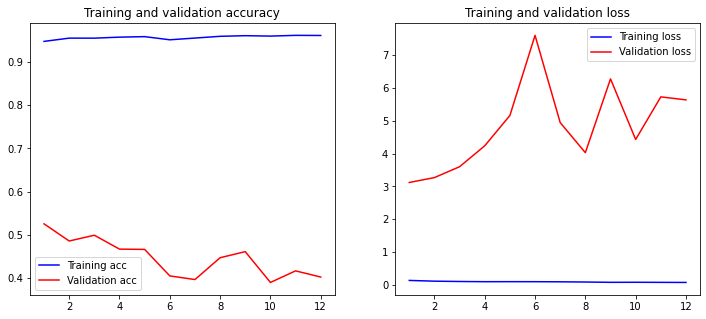

In [70]:
plot_history(history)

#### XLNet

In [342]:
#! pip uninstall torch torchvision -y
#! pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
#! pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html
#! pip install -U transformers
#! pip install -U simpletransformers 
# pip install torch

In [343]:
#pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0 --extra-index-url https://download.pytorch.org/whl/cu113


In [344]:
# splitting the data into training and eval dataset
X = df['Avis.Pharmaceutique']
y = df['PLT']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

train_df = pd.DataFrame(X_train)
train_df['PLT'] = y_train

eval_df = pd.DataFrame(X_test)
eval_df['PLT'] = y_test

train_df.shape, eval_df.shape

((18512, 2), (4629, 2))

In [345]:
train_df

,Avis.Pharmaceutique,PLT
12044,gelules mg,0.0
6531,absence donnee efficacite tolerance cp ecrases...,0.0
1121,indication trouvee reevaluer necessite,1.0
1734,reference hus propose movicol dotation service lb,0.0
12951,coversyl mg perindopril mg cpr equivalence dos...,0.0
...,...,...
7607,patient esidrex hydrochlorothiazide mg cp hd,0.0
5592,fin jours ttt agnes,0.0
1470,indique atarax hydroxysine risque majore torsa...,1.0
18503,substituer gel larmes,0.0


In [346]:
from simpletransformers.classification import ClassificationModel
import pandas as pd
import logging
import sklearn


logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# They are lot of arguments to play with
'''
args = {
   'output_dir': 'outputs/',
   'cache_dir': 'cache/',
   'fp16': True,
   'fp16_opt_level': 'O1',
   'max_seq_length': 256,
   'train_batch_size': 8,
   'eval_batch_size': 8,
   'gradient_accumulation_steps': 1,
   'num_train_epochs': 3,
   'weight_decay': 0,
   'learning_rate': 4e-5,
   'adam_epsilon': 1e-8,
   'warmup_ratio': 0.06,
   'warmup_steps': 0,
   'max_grad_norm': 1.0,
   'logging_steps': 50,
   'evaluate_during_training': False,
   'save_steps': 2000,
   'eval_all_checkpoints': True,
   'use_tensorboard': True,
   'overwrite_output_dir': True,
   'reprocess_input_data': False,
}
'''



"\nargs = {\n   'output_dir': 'outputs/',\n   'cache_dir': 'cache/',\n   'fp16': True,\n   'fp16_opt_level': 'O1',\n   'max_seq_length': 256,\n   'train_batch_size': 8,\n   'eval_batch_size': 8,\n   'gradient_accumulation_steps': 1,\n   'num_train_epochs': 3,\n   'weight_decay': 0,\n   'learning_rate': 4e-5,\n   'adam_epsilon': 1e-8,\n   'warmup_ratio': 0.06,\n   'warmup_steps': 0,\n   'max_grad_norm': 1.0,\n   'logging_steps': 50,\n   'evaluate_during_training': False,\n   'save_steps': 2000,\n   'eval_all_checkpoints': True,\n   'use_tensorboard': True,\n   'overwrite_output_dir': True,\n   'reprocess_input_data': False,\n}\n"

In [347]:
import torch
torch.cuda.empty_cache()

In [348]:
torch.cuda.is_available()

True

In [349]:
torch.zeros(1).cuda()


tensor([0.], device='cuda:0')

In [362]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
model_args = ClassificationArgs(num_train_epochs=4,overwrite_output_dir=True,train_batch_size=32,max_seq_length=40)
# Create a ClassificationModel
model = ClassificationModel('xlnet', 'xlnet-base-cased', args=model_args,weight=[0.6,2.5]) # You can set class weights by using the optional weight argument

# Train the model
model.train_model(train_df)

# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(eval_df, acc=sklearn.metrics.accuracy_score)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

  0%|          | 0/18512 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_xlnet_40_2_2


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/579 [00:00<?, ?it/s]

C:\Users\murat\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Running Epoch 1 of 4:   0%|          | 0/579 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/579 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/579 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of xlnet model complete. Saved to outputs/.
C:\Users\murat\anaconda3\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/4629 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_40_2_2


Running Evaluation:   0%|          | 0/579 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.7472234254911528, 'tp': 772, 'tn': 3466, 'fp': 257, 'fn': 134, 'auroc': 0.9656051903358337, 'auprc': 0.9045677631277477, 'acc': 0.9155325124216893, 'eval_loss': 0.30021490547617025}


In [363]:
predictions, raw_outputs = model.predict(X_test.tolist())

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/4629 [00:00<?, ?it/s]

  0%|          | 0/579 [00:00<?, ?it/s]

In [ ]:
predictions

In [364]:
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))

              precision    recall  f1-score   support

         0.0       0.96      0.93      0.95      3723
         1.0       0.75      0.85      0.80       906

    accuracy                           0.92      4629
   macro avg       0.86      0.89      0.87      4629
weighted avg       0.92      0.92      0.92      4629

[[3466  257]
 [ 134  772]]


In [ ]:
#### Without numbers

In [31]:
# Create a ClassificationModel
model = ClassificationModel("roberta", "roberta-base", args={'num_train_epochs':4, 'train_batch_size':32, 'max_seq_length':40,'overwrite_output_dir': True}) # You can set class weights by using the optional weight argument

# Train the model
model.train_model(train_df)

# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(eval_df, acc=sklearn.metrics.accuracy_score)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/18512 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_40_2_2


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/579 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/579 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/579 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/579 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
C:\Users\murat\anaconda3\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/4629 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_40_2_2


Running Evaluation:   0%|          | 0/579 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.7573027732510283, 'tp': 700, 'tn': 3584, 'fp': 139, 'fn': 206, 'auroc': 0.9626615531755053, 'auprc': 0.8931586617957168, 'acc': 0.9254698639014906, 'eval_loss': 0.22275299306344465}


In [32]:
predictions, raw_outputs = model.predict(X_test.tolist())

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/4629 [00:00<?, ?it/s]

  0%|          | 0/579 [00:00<?, ?it/s]

In [33]:
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95      3723
           1       0.83      0.77      0.80       906

    accuracy                           0.93      4629
   macro avg       0.89      0.87      0.88      4629
weighted avg       0.92      0.93      0.92      4629

[[3584  139]
 [ 206  700]]
